# imports

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

# supress the warnings
import warnings
warnings.filterwarnings('ignore')
# supress ConvergenceWarning
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [2]:
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', ''):  
    train_df_ = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
    test_df_ = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
else:
    train_df_ = pd.read_csv('data/train.csv')
    test_df_ = pd.read_csv('data/test.csv')

# Preprocess

In [3]:
y_train = train_df_['Class']
train_df = train_df_.drop('Class', axis=1)

ids = test_df_['Id']
train_df.drop('Id', axis=1, inplace=True)
test_df = test_df_.drop('Id', axis=1)

In [4]:
# do one-hot encoding to EJ column

train_df['EJ'] = train_df['EJ'].apply(lambda x: 1 if x == 'Yes' else 0)
test_df['EJ'] = test_df['EJ'].apply(lambda x: 1 if x == 'Yes' else 0)

In [5]:
# Fill missing values with median if less than 3 values are missing else impute with KNN imputer

col_fill_na_median = []
col_fill_na_knn = []

for col in train_df.columns:
    if train_df[col].isnull().sum() > 2:
        col_fill_na_knn.append(col)
    elif train_df[col].isnull().sum() > 0:
        col_fill_na_median.append(col)
        
print('Columns to fill with median: ', col_fill_na_median)
print('Columns to fill with KNN: ', col_fill_na_knn)

Columns to fill with median:  ['CB', 'DU', 'FC', 'FL', 'FS', 'GL']
Columns to fill with KNN:  ['BQ', 'CC', 'EL']


In [6]:
# fill missing values with mdeian

transformers_1 = []
transformers_1.append(
    (
        "median_imputer",
        SimpleImputer(
            strategy="median",
        ),
        col_fill_na_median,
    )
)

# fill missing values with KNN

transformers_1.append(
    (
        "knn_imputer",
        KNNImputer(
            n_neighbors=5,
        ),
        col_fill_na_knn,
    )
)

print(transformers_1)

preprocessor = ColumnTransformer(transformers=transformers_1, remainder='passthrough')

scaler = StandardScaler()


pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('scaler', scaler)])
pipeline

[('median_imputer', SimpleImputer(strategy='median'), ['CB', 'DU', 'FC', 'FL', 'FS', 'GL']), ('knn_imputer', KNNImputer(), ['BQ', 'CC', 'EL'])]


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('median_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['CB', 'DU', 'FC', 'FL', 'FS',
                                                   'GL']),
                                                 ('knn_imputer', KNNImputer(),
                                                  ['BQ', 'CC', 'EL'])])),
                ('scaler', StandardScaler())])

In [7]:
train_data = pipeline.fit_transform(train_df)
test_data = pipeline.transform(test_df)

# Training

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import uniform
from sklearn.metrics import  make_scorer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

## Train-test split

In [9]:
train_X, test_X, train_Y, test_Y = train_test_split(train_data, y_train, test_size=0.2, random_state=42)

## Helper functions

In [10]:
def balanced_log_loss(y_true, y_pred):
#     y_pred = estimator.predict_proba(X)
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)

    # calculate the weights for each class
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    epsilon = 1e-10
    # calculate the predicted probabilities for each class
    p = np.clip(y_pred, 1e-15, 1 - 1e-15)
#     p_1 = np.clip(y_pred[:, 1], 1e-15, 1 - 1e-15)
    # calculate the log loss for each class
    log_loss_0 = -w_0 * np.sum(y_true * np.log(1-p+1e-10))
    log_loss_1 = -w_1 * np.sum(y_true * np.log(p))

    # calculate the balanced logarithmic loss
    balanced_log_loss = (log_loss_0 + log_loss_1) / 2

    return balanced_log_loss


custom_scoring = make_scorer(balanced_log_loss,greater_is_better=False,  needs_proba=True)


# custom scoring function
# def custom_scorer(y_true, y_pred):
#     # balanced log loss
#     N_0 = np.sum(y_true == 0)
#     N_1 = np.sum(y_true == 1)
    
#     y_pred =  np.clip(y_pred, 1e-15, 1 - 1e-15)

#     log_loss_0 = np.sum(y_true[y_true == 0] * np.log(y_pred[y_true == 0]))

#     log_loss_1 = np.sum(y_true[y_true == 1] * np.log(y_pred[y_true == 1]))

#     return -(log_loss_0 / N_0 + log_loss_1 / N_1) / 2

# custom_scoring = make_scorer(custom_scorer, greater_is_better=False)

In [11]:
def train_model(X_train, y_train, X_test, y_test, model):
    """
    This function trains a model and prints the accuracy score for both the train and test sets
    """
    model.fit(X_train, y_train)
#     print('Train accuracy score: ', model.score(X_train, y_train))
#     print('Test accuracy score: ', model.score(X_test, y_test))
    print('Train Balanced Logarithmic Loss: ', -custom_scoring(model, X_train, y_train))
    print('Test Balanced Logarithmic Loss: ', -custom_scoring(model, X_test, y_test))

def grid_search(X_train, y_train, model, param_grid, cv=5, scoring=None):
    """
    This function performs grid search on the given model and prints the best parameters
    """
    grid = GridSearchCV(model, param_grid, cv=cv, verbose=1, scoring=scoring, refit= True, n_jobs=-1)
    grid.fit(X_train, y_train)
    print('Best parameters: ', grid.best_params_)
#     print('Best score: ', grid.best_score_)
    model = grid
    print('Train Balanced Logarithmic Loss: ', -custom_scoring(model, X_train, y_train))
    print('Test Balanced Logarithmic Loss: ', -custom_scoring(model, test_X, test_Y))
    return grid.best_params_, model

def plot_confusion_matrix(X_train, y_train, X_test, y_test, model):
    """
    This function plots the confusion matrix for both the train and test sets
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(confusion_matrix(y_train, model.predict(X_train)), annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Confusion Matrix')
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')
    sns.heatmap(
        confusion_matrix(y_test, model.predict(X_test)), annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Confusion Matrix')
    ax[1].set_xlabel('Predicted Label')
    ax[1].set_ylabel('True Label')
    plt.tight_layout()
    

# display classification report
def classification_report_df(model):
    """
    This function prints the classification report for both the train and test sets
    """
    print('Train Classification Report')
    print(classification_report(train_Y, model.predict(train_X)))
    print('Test Classification Report')
    print(classification_report(test_Y, model.predict(test_X)))

## Logistic Regression

In [14]:
# create the LogisticRegression object, giving the class_weight parameter
lg = LogisticRegression(class_weight='balanced')

# train the model
train_model(train_X, train_Y, test_X, test_Y, lg)

Train Balanced Logarithmic Loss:  0.5753806167407706
Test Balanced Logarithmic Loss:  0.5377045389944048


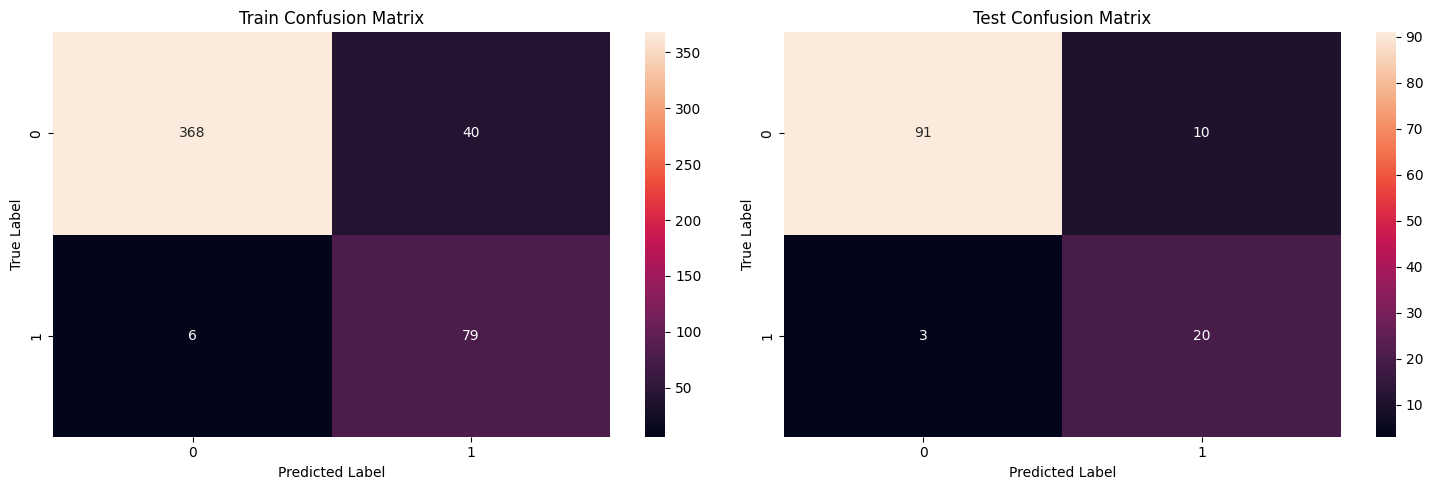

In [15]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, lg)

In [16]:
classification_report_df(lg)

Train Classification Report
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       408
           1       0.66      0.93      0.77        85

    accuracy                           0.91       493
   macro avg       0.82      0.92      0.86       493
weighted avg       0.93      0.91      0.91       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       101
           1       0.67      0.87      0.75        23

    accuracy                           0.90       124
   macro avg       0.82      0.89      0.84       124
weighted avg       0.91      0.90      0.90       124



- let's try to tune some hyperparameters to see if we can get better results.

In [17]:
# create the LogisticRegression object, giving the class_weight parameter
grid_lg = LogisticRegression(class_weight='balanced', n_jobs=-1)

distribs = {
    "penalty": ['l1', 'l2'],
    "C" : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "max_iter" : [1000],
    "solver" : ['saga', 'lbfgs']
}

# train the model
best_params, grid_lg = grid_search(train_X, train_Y, grid_lg, distribs, cv=5, scoring=custom_scoring)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


/home/shailja/.virtualenv/my_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shailja/.virtualenv/my_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shailja/.virtualenv/my_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shailja/.virtualenv/my_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shailja/.virtualenv/my_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shailja/.

Best parameters:  {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Train Balanced Logarithmic Loss:  0.37017692271628344
Test Balanced Logarithmic Loss:  0.3956452450972181


/home/shailja/.virtualenv/my_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shailja/.virtualenv/my_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


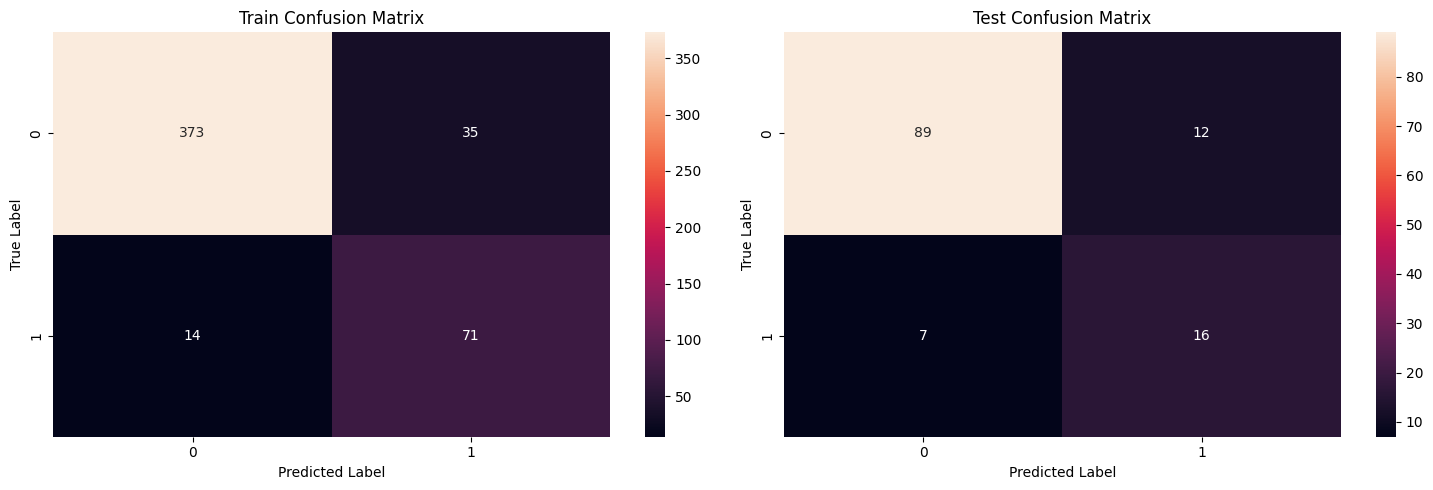

In [18]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, grid_lg)

In [19]:
classification_report_df(grid_lg)

Train Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       408
           1       0.67      0.84      0.74        85

    accuracy                           0.90       493
   macro avg       0.82      0.87      0.84       493
weighted avg       0.91      0.90      0.90       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       101
           1       0.57      0.70      0.63        23

    accuracy                           0.85       124
   macro avg       0.75      0.79      0.77       124
weighted avg       0.86      0.85      0.85       124



## SVM

### Kernel `rbf`

In [20]:
svm_rbf = SVC(kernel='rbf', class_weight='balanced', probability=True)

# train the model
train_model(train_X, train_Y, test_X, test_Y, svm_rbf)

Train Balanced Logarithmic Loss:  0.35137249700018663
Test Balanced Logarithmic Loss:  0.4983423334569974


### Kernel `linear`

In [21]:
svm_linear = SVC(kernel='linear', class_weight='balanced', probability=True)

# train the model
train_model(train_X, train_Y, test_X, test_Y, svm_linear)

Train Balanced Logarithmic Loss:  0.6055927182972669
Test Balanced Logarithmic Loss:  0.5952983897950582


- `linear` kernel is performing worse than `rbf` kernel.

### Kernel `poly`

In [22]:
svm_poly = SVC(kernel='poly', class_weight='balanced', probability=True)

# train the model
train_model(train_X, train_Y, test_X, test_Y, svm_poly)

Train Balanced Logarithmic Loss:  0.6601102560601376
Test Balanced Logarithmic Loss:  0.7786942894058142


- more worst than `linear` kernel.

- So we will do a hyperparameter tuning for `rbf` and `linear` kernels. and `poly` kernel with different degrees.

In [23]:
grid_svm = SVC(class_weight='balanced', probability=True)

distribs = {
    "kernel": ['rbf', 'linear', 'poly'],
    "C" : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "degree" : [2, 3, 4, 5],
    "gamma" : ['scale', 'auto'],
    'shrinking' : [True, False],
}

# train the model
best_params, grid_svm = grid_search(train_X, train_Y, grid_svm, distribs, cv=5, scoring=custom_scoring)

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Best parameters:  {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}
Train Balanced Logarithmic Loss:  0.3179409085486552
Test Balanced Logarithmic Loss:  0.5017609024060885


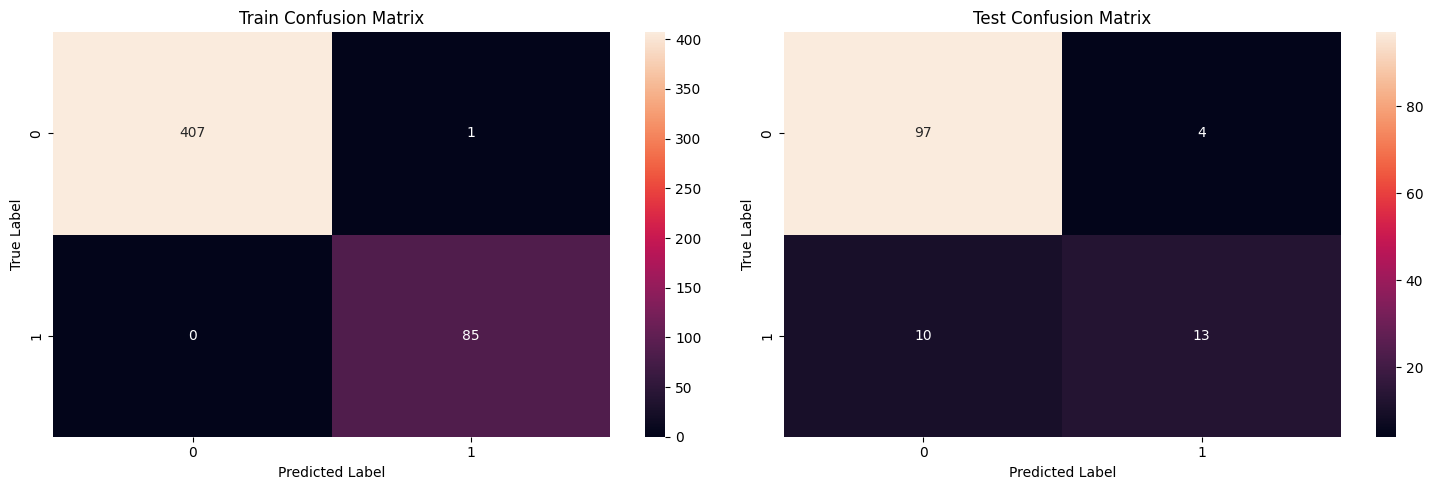

In [24]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, grid_svm)

In [25]:
classification_report_df(grid_svm)

Train Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       408
           1       0.99      1.00      0.99        85

    accuracy                           1.00       493
   macro avg       0.99      1.00      1.00       493
weighted avg       1.00      1.00      1.00       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       101
           1       0.76      0.57      0.65        23

    accuracy                           0.89       124
   macro avg       0.84      0.76      0.79       124
weighted avg       0.88      0.89      0.88       124



- let's try to find the best hyperparameters for `rbf` kernel.

In [12]:
grid_svm2 = SVC(class_weight='balanced', probability=True)

distribs = {
    "kernel": ['rbf'],
    "C" : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "gamma" : ['scale', 'auto'],
    'shrinking' : [True],
}

# train the model
best_params, grid_svm2 = grid_search(train_X, train_Y, grid_svm2, distribs, cv=5, scoring=custom_scoring)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best parameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}
Train Balanced Logarithmic Loss:  0.306851967482877
Test Balanced Logarithmic Loss:  0.5072446278713247


- Almost same results as before. So we will stop here.

In [13]:
best_params

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}

## Decision Tree

In [18]:
# import the DecisionTreeClassifier class
from sklearn.tree import DecisionTreeClassifier

# create the DecisionTreeClassifier object, giving the class_weight parameter
dt = DecisionTreeClassifier(class_weight='balanced')

# train the model
train_model(train_X, train_Y, test_X, test_Y, dt)

Train Balanced Logarithmic Loss:  2.398525097706579
Test Balanced Logarithmic Loss:  7.079729740930597


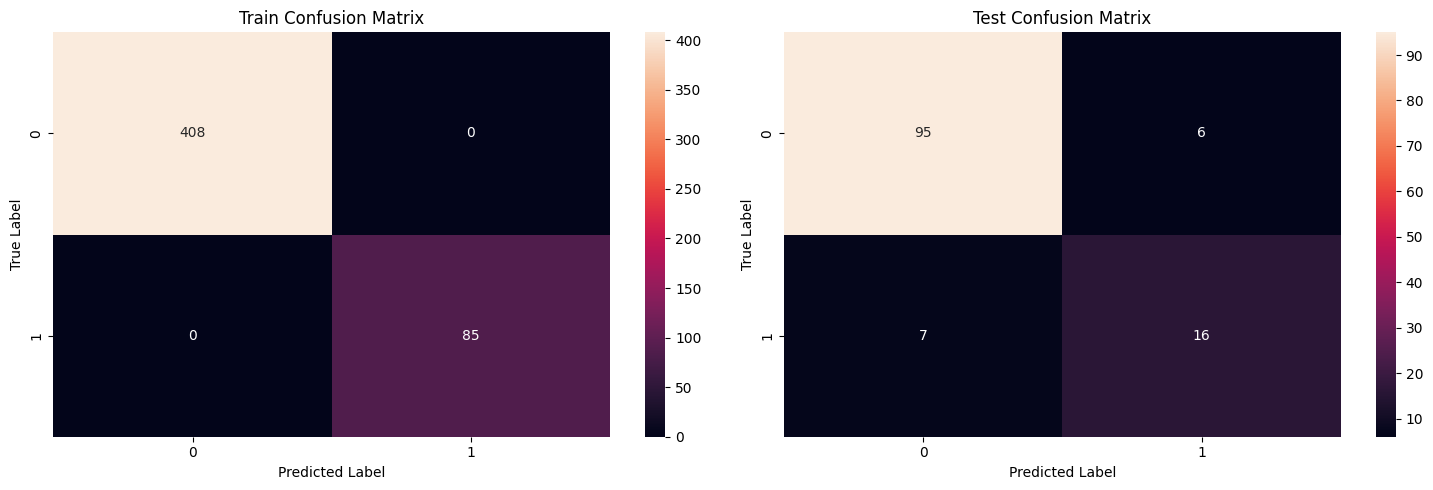

In [19]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, dt)

- It is clearlly overfitting.

In [20]:
grid_dt = DecisionTreeClassifier(class_weight='balanced')

distribs = {
    "criterion": ['gini', 'entropy'],
    "splitter" : ['best', 'random'],
    "max_depth" : [None, 2, 6, 7, 10],
    "min_samples_split" : [2, 6, 10],
    "min_samples_leaf" : [1,  6,  10],
    "max_features" : ['auto', 'sqrt', 'log2']
}

# train the model
best_params, grid_dt = grid_search(train_X, train_Y, grid_dt, distribs, cv=5, scoring=custom_scoring)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


/home/shailja/.virtualenv/my_env/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/shailja/.virtualenv/my_env/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/shailja/.virtualenv/my_env/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/shailja/.virtualenv/my_env/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the pas

Best parameters:  {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 6, 'splitter': 'random'}
Train Balanced Logarithmic Loss:  0.4163564974497398
Test Balanced Logarithmic Loss:  0.44580796185382093


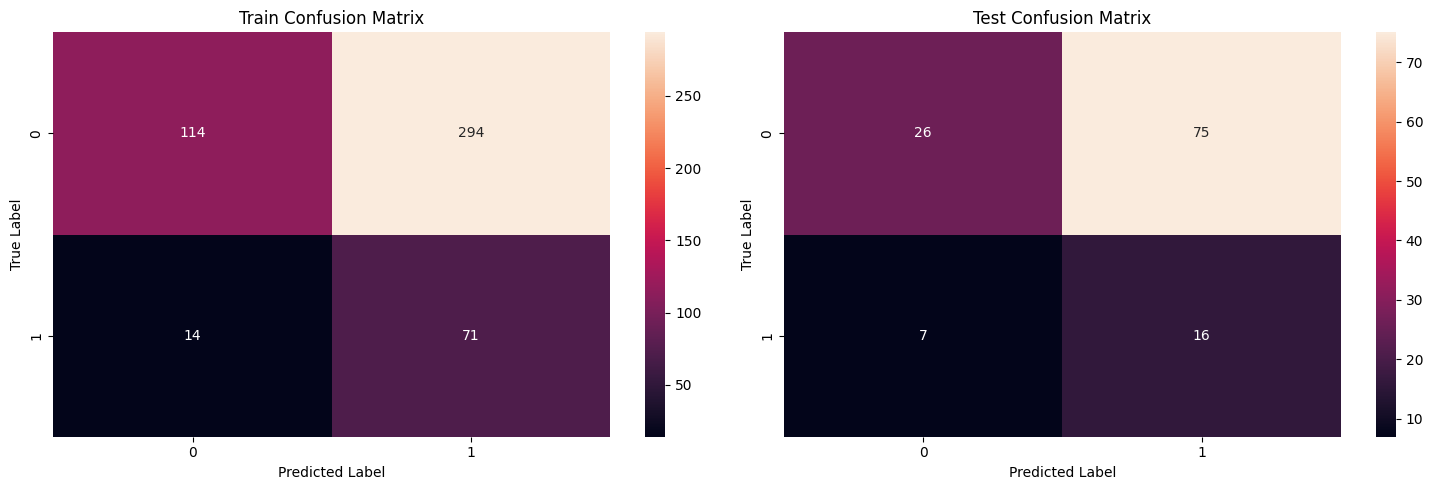

In [21]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, grid_dt)

In [22]:
classification_report_df(grid_dt)

Train Classification Report
              precision    recall  f1-score   support

           0       0.89      0.28      0.43       408
           1       0.19      0.84      0.32        85

    accuracy                           0.38       493
   macro avg       0.54      0.56      0.37       493
weighted avg       0.77      0.38      0.41       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.79      0.26      0.39       101
           1       0.18      0.70      0.28        23

    accuracy                           0.34       124
   macro avg       0.48      0.48      0.33       124
weighted avg       0.67      0.34      0.37       124



### Random Forest

In [23]:
# create the RandomForestClassifier object, giving the class_weight parameter
rf = RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=100, min_samples_split=4, min_samples_leaf=1)


# train the model
train_model(train_X, train_Y, test_X, test_Y, rf)

Train Balanced Logarithmic Loss:  0.2996712105063831
Test Balanced Logarithmic Loss:  0.3886684566242277


- This is performing better, let's do a Grid Search to hypertune

In [24]:
grid_rf = RandomForestClassifier(class_weight='balanced')

distribs = {
    "n_estimators": [100, 200, 300, 400, 500],
    "criterion" : ['gini', 'entropy'],
    "max_depth" : [None, 2,  7, 14],
    "min_samples_split" : [2, 7, 14],
    "min_samples_leaf" : [1, 7, 14],

}

# train the model
best_params, grid_rf = grid_search(train_X, train_Y, grid_rf, distribs, cv=5, scoring=custom_scoring)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 14, 'min_samples_split': 2, 'n_estimators': 300}
Train Balanced Logarithmic Loss:  0.3071985966101604
Test Balanced Logarithmic Loss:  0.35016611257629754


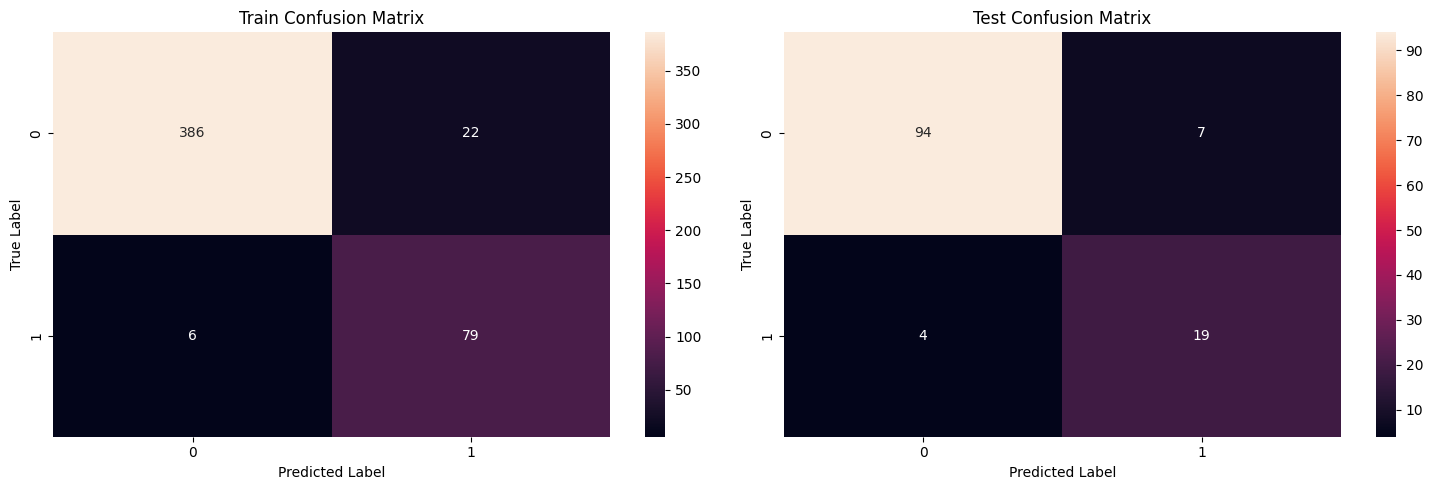

In [25]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, grid_rf)

In [26]:
classification_report_df(grid_rf)

Train Classification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       408
           1       0.78      0.93      0.85        85

    accuracy                           0.94       493
   macro avg       0.88      0.94      0.91       493
weighted avg       0.95      0.94      0.95       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       101
           1       0.73      0.83      0.78        23

    accuracy                           0.91       124
   macro avg       0.84      0.88      0.86       124
weighted avg       0.92      0.91      0.91       124



- Better results than before. Let's try to find the best hyperparameter in smaller range.

In [27]:
best_params

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 14,
 'min_samples_split': 2,
 'n_estimators': 300}

In [29]:
grid_rf2 = RandomForestClassifier(class_weight='balanced')

distribs = {
    "n_estimators": [250, 300, 350],
    "criterion" : ['gini'],
    "max_depth" : [None],
    "min_samples_split" : [1,2,3],
    "min_samples_leaf" : [13, 14, 15],

}

# train the model
best_params, grid_rf2 = grid_search(train_X, train_Y, grid_rf2, distribs, cv=5, scoring=custom_scoring)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 14, 'min_samples_split': 3, 'n_estimators': 350}
Train Balanced Logarithmic Loss:  0.3065680241969585
Test Balanced Logarithmic Loss:  0.3533760667634736


In [30]:
best_params

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 14,
 'min_samples_split': 3,
 'n_estimators': 350}

- As the results are almost same hence, stop here.

## XGBoost

In [18]:
# create the XGBClassifier object, giving the class_weight parameter
xgb = XGBClassifier(scale_pos_weight=3, max_depth=3, n_estimators=60, min_child_weight=20)

# train the model
train_model(train_X, train_Y, test_X, test_Y, xgb)

Train Balanced Logarithmic Loss:  0.31957767855047303
Test Balanced Logarithmic Loss:  0.4038110729573544


- Let's tune the hyperparameters

In [ ]:
grid_xgb = XGBClassifier(scale_pos_weight=3)

distribs = {
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "n_estimators" : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "min_child_weight" : [1, 5, 10, 15, 20, 25, 30, 35, 40],
    "gamma" : [0.0, 0.1, 0.2, 0.3, 0.4],
    "subsample" : [0.5, 0.6, 0.7, 0.8, 0.9],
    "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9],
    "learning_rate" : [0.01, 0.05, 0.1, 0.15, 0.2]
}

# train the model
best_params, grid_xgb = grid_search(train_X, train_Y, grid_xgb, distribs, cv=5, scoring=custom_scoring)

## CatBoost

In [ ]:
# create the CatBoostClassifier object, giving the class_weight parameter
cat = CatBoostClassifier(class_weights=[1, 3], max_depth=3, n_estimators=40)

# train the model
train_model(train_X, train_Y, test_X, test_Y, cat)

## Let's try to make the Ensemble

- Weights to each model will be given according to their performance on the test data.

In [ ]:
# create the EnsembleVoteClassifier object, giving the class_weight parameter
vc = VotingClassifier(estimators=[('lg', lg), ('svm_linear', svm_linear), ('dt', dt), ('rf', rf), ('xgb', xgb), ('cat', cat)], voting='soft', weights=[1, 2, 1, 0.95, 1.4, 1.2])

# train the model
train_model(train_X, train_Y, test_X, test_Y, vc)

In [ ]:
# Training the VC on whole dataset and predicting on test dataset
vc_final = VotingClassifier(estimators=[('lg', lg), ('svm_linear', svm_linear), ('dt', dt), ('rf', rf), ('xgb', xgb), ('cat', cat)], voting='soft', weights=[1, 2, 1, 0.95, 1.4, 1.2])
vc_final.fit(X_train_, y_train)

# Predictions

In [ ]:
# Predicting on test dataset
y_pred = vc_final.predict_proba(X_test_)

In [ ]:
y_pred[:, 1] = np.maximum(np.minimum(y_pred[:, 1], 1-1e-15), 1e-15)
y_pred[:, 0] = np.maximum(np.minimum(y_pred[:, 0], 1-1e-15), 1e-15)

In [ ]:
# y_pred

In [ ]:
submission = pd.DataFrame({'Id': ids, 'class_0': y_pred[:, 0], 'class_1': y_pred[:, 1]})

In [ ]:
submission.to_csv('submission.csv', index=False)